### Comparing Bitcoin's Percent Change Return to Change in Inflation to Predict Investment Return

In this analysis, we attempt to examine Bitcoin's percent change data compared to inflation and determine if such data can be used to predict return on future Bitcoin investments.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

### Data Collection and Labeling

In [2]:
# Focus on Bitcoin Here

coin_df = pd.read_csv('Data/coin_Bitcoin.csv')

coin_df.index = pd.to_datetime(coin_df['Date']).dt.date
coin_df.index = pd.DatetimeIndex(coin_df.index)

# Not useful
coin_df.drop('Date', axis=1, inplace=True)
coin_df.drop('SNo', axis=1, inplace=True)
coin_df.drop('Symbol', axis=1, inplace=True)
coin_df.drop('Name', axis=1, inplace=True)

coin_df.head()

,High,Low,Open,Close,Volume,Marketcap
Date,,,,,,
2013-04-29,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
2013-04-30,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2013-05-01,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
2013-05-02,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
2013-05-03,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


In [3]:
# Focus on Inflation Here
inflation_df = pd.read_csv('FRED_CPI_Datasets/T10YIE.csv')

inflation_df.index = pd.to_datetime(inflation_df['DATE']).dt.date
inflation_df.index = pd.DatetimeIndex(inflation_df.index)

inflation_df['T10YIE'] = pd.to_numeric(inflation_df['T10YIE'],errors='coerce')
# Not useful
inflation_df.drop('DATE', axis=1, inplace=True)

inflation_df.head()

,T10YIE
DATE,
2016-04-12,1.57
2016-04-13,1.56
2016-04-14,1.56
2016-04-15,1.56
2016-04-18,1.57


In [4]:
# Add a classification column. The class of each data point is determined by the percent change in close price
# day by day
coin_df['Return'] = coin_df['Close'].pct_change()
# First row in df has NaN 'return' since there is no previous day
coin_df.drop(coin_df.index[0], inplace=True)
coin_df.head()

,High,Low,Open,Close,Volume,Marketcap,Return
Date,,,,,,,
2013-04-30,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09,-0.038328
2013-05-01,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09,-0.158345
2013-05-02,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09,-0.100692
2013-05-03,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09,-0.070906
2013-05-04,115.000000,92.500000,98.099998,112.500000,0.0,1.250317e+09,0.150895


In [5]:
# Add a classification column. The class of each data point is determined by the percent change in close price
# day by day
inflation_df['BTC_Return'] = coin_df['Return'].pct_change()
#inflation_df['Return'] = pd.to_numeric(inflation_df['Return'],errors='coerce')
# First row in df has NaN 'return' since there is no previous day
inflation_df.drop(inflation_df.index[0], inplace=True)
inflation_df.head()

,T10YIE,BTC_Return
DATE,,
2016-04-13,1.56,-1.534438
2016-04-14,1.56,-1.377671
2016-04-15,1.56,8.897708
2016-04-18,1.57,-1.378463
2016-04-19,1.60,4.787469


### Data Visualization

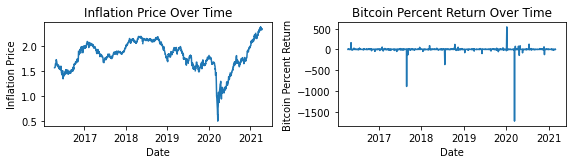

In [6]:
# A basic visualization of Date vs the inflation_df columns
fig = plt.figure(figsize=(12, 6))

# Inflation over time
high_axis = fig.add_subplot(3, 3, 1)
high_axis.plot(inflation_df.index, inflation_df['T10YIE'])
high_axis.set_title('Inflation Price Over Time')
high_axis.set_xlabel('Date')
high_axis.set_ylabel('Inflation Price')



# Return over time
return_axis = fig.add_subplot(3, 3, 2)
return_axis.plot(inflation_df.index, inflation_df['BTC_Return'])
return_axis.set_title('Bitcoin Percent Return Over Time')
return_axis.set_xlabel('Date')
return_axis.set_ylabel('Bitcoin Percent Return')

plt.tight_layout()
plt.show()

---

### Class Assignment

In [7]:
def get_sentiment(return_value):
    if return_value >= 0.10:
        return 'very good'
    elif return_value > 0 and return_value < 0.10:
        return 'good'
    elif return_value <= 0 and return_value > -0.10:
        return 'bad'
    elif return_value <= -0.10:
        return 'very bad'
    else:
        return None
# Replace Return column with label
inflation_df['BTC_Return'] = [get_sentiment(return_value) for return_value in inflation_df['BTC_Return']]
inflation_df.dropna(inplace=True)
inflation_df.head()

,T10YIE,BTC_Return
DATE,,
2016-04-13,1.56,very bad
2016-04-14,1.56,very bad
2016-04-15,1.56,very good
2016-04-18,1.57,very bad
2016-04-19,1.60,very good


In [8]:
# We are faced with a new problem: Class Imbalance. This will be addressed in the next section
inflation_class_counts = {}
for class_ in inflation_df['BTC_Return']:
    inflation_class_counts[class_] = inflation_class_counts.get(class_, 0) + 1
print(inflation_class_counts)

{'very bad': 879, 'very good': 295, 'good': 19, 'bad': 26}


---

### Model Evaluation/Parameter Tuning

In the next few code blocks, we deal with Class Imbalance issues, and evaluate multiple models with fine-tuned parameters.

In [9]:
# To decide on the best model, we should fine tune the parameters of the models in consideration to see
# the best performances of our models.

# Because Bitcoin prices can be very volatile with plenty of outliers,
# we use RobustScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV

X = inflation_df[['T10YIE']]
y = inflation_df['BTC_Return']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

transformer = RobustScaler().fit(X_train)
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

In [10]:
inflation_df.dropna(0)

,T10YIE,BTC_Return
DATE,,
2016-04-13,1.56,very bad
2016-04-14,1.56,very bad
2016-04-15,1.56,very good
2016-04-18,1.57,very bad
2016-04-19,1.60,very good
...,...,...
2021-02-22,2.16,very bad
2021-02-23,2.16,very good
2021-02-24,2.17,very bad


### Class Imbalance

As we saw above, the number of "good" vs "bad" data points heavily outweigh the "very good" and "very bad" data points. In the next cell, we attempt to assign class weights to account for this disparity.

In [12]:
# We should now deal with the issue of class_weights
from sklearn.utils import class_weight
labels = np.unique(y_train)
class_weights = dict(zip(labels, class_weight.compute_class_weight('balanced', classes=labels, y=y_train)))
print(class_weights)

{'bad': 12.544117647058824, 'good': 23.694444444444443, 'very bad': 0.3384920634920635, 'very good': 1.08248730964467}


### Logistic Regression Evaluation

In [13]:
# Logistic Regression Parameter Tuning
from sklearn.linear_model import LogisticRegression
param_grid = {  'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
                }

lr = LogisticRegression(max_iter=2000, class_weight=class_weights)
grid = GridSearchCV(lr, param_grid)
grid.fit(X_train, y_train)
# lr_pred = lr.predict(X_test)
# print('Logistic Reg Score: {:.2f}'.format(lr.score(X_test, y_test)))
print("Best grid score: {:.2f}".format(grid.best_score_))
print("Grid test score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best grid parameters: {}".format(grid.best_params_))
lr_best_params = grid.best_params_

Best grid score: 0.23
Grid test score: 0.38
Best grid parameters: {'C': 1}


### Decision Tree Evaluation

In [14]:
# Decision Tree Parameter Tuning
from sklearn.tree import DecisionTreeClassifier
n_components = list(range(1,X.shape[1]+1,1))
criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2,4,6,8,10,12,14,16,18,20,25,30,40,50,70]
}
dt = DecisionTreeClassifier(class_weight=class_weights)
grid = GridSearchCV(dt, param_grid)
grid.fit(X_train, y_train)
print("Best grid score: {:.2f}".format(grid.best_score_))
print("Grid test score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best grid parameters: {}".format(grid.best_params_))
dt_best_params = grid.best_params_

Best grid score: 0.41
Grid test score: 0.35
Best grid parameters: {'criterion': 'gini', 'max_depth': 18}


### KNN Evaluation

In [15]:
# K-Nearest Neighbors Parameter Tuning
from sklearn.neighbors import KNeighborsClassifier
param_grid = {
    'n_neighbors': [3, 5, 11, 19],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
knn = KNeighborsClassifier() # No class_weight param
grid = GridSearchCV(knn, param_grid)
grid.fit(X_train, y_train)
print("Best grid score: {:.2f}".format(grid.best_score_))
print("Grid test score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best grid parameters: {}".format(grid.best_params_))
knn_best_params = grid.best_params_

Best grid score: 0.74
Grid test score: 0.67
Best grid parameters: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'}


### SVC Evaluation

In [16]:
# SVC Parameter Tuning
from sklearn.svm import SVC
param_grid = {
    'C':[1,10,100,1000],
    'gamma':[1,0.1,0.001,0.0001],
    'kernel':['linear','rbf']
}
svc = SVC(class_weight=class_weights)
grid = GridSearchCV(svc, param_grid)
grid.fit(X_train, y_train)
print("Best grid score: {:.2f}".format(grid.best_score_))
print("Grid test score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best grid parameters: {}".format(grid.best_params_))
svc_best_params = grid.best_params_

Best grid score: 0.26
Grid test score: 0.18
Best grid parameters: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}


### Retraining with Best Parameters

In [17]:
# Let's retrain the models using the fine-tuned parameters found
# so we can examine the confusion matrix and scoring report and make a conclusion.
lr = LogisticRegression(max_iter=2000, C=lr_best_params['C'], class_weight=class_weights)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
print('Logistic Regression Score: {:.2f}'.format(lr.score(X_test, y_test)))

dt = DecisionTreeClassifier(criterion=dt_best_params['criterion'], max_depth=dt_best_params['max_depth'], class_weight=class_weights)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
print('Decision Tree Score: {:.2f}'.format(dt.score(X_test, y_test)))

knn = KNeighborsClassifier(metric=knn_best_params['metric'], n_neighbors=knn_best_params['n_neighbors'], weights=knn_best_params['weights'])
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
print('KNN Score: {:.2f}'.format(knn.score(X_test, y_test)))

svc = SVC(C=svc_best_params['C'], gamma=svc_best_params['gamma'], kernel=svc_best_params['kernel'], class_weight=class_weights)
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)
print('SVC Score: {:.2f}'.format(svc.score(X_test, y_test)))

Logistic Regression Score: 0.38
Decision Tree Score: 0.35
KNN Score: 0.67
SVC Score: 0.18


---

### Score Reporting

Here, we take a closer look at the performance of our models, as raw accuracy is often not a great indicator.

### Confusion Matrices

In [18]:
from sklearn.metrics import confusion_matrix
labels = ["Bad", "Good", "Very Good", "Very Bad"]
print("Logistic Regression Confusion Matrix:")
print(pd.DataFrame(confusion_matrix(y_test, lr_pred), index=labels, columns=labels), '\n')
print("Decision Tree Classifier Confusion Matrix:")
print(pd.DataFrame(confusion_matrix(y_test, dt_pred), index=labels, columns=labels), '\n')
print("KNN Classifier Confusion Matrix:")
print(pd.DataFrame(confusion_matrix(y_test, knn_pred), index=labels, columns=labels), '\n')
print("SVC Classifier Confusion Matrix:")
print(pd.DataFrame(confusion_matrix(y_test, svc_pred), index=labels, columns=labels), '\n')

Logistic Regression Confusion Matrix:
           Bad  Good  Very Good  Very Bad
Bad          4     0          5         0
Good         1     1          8         0
Very Good  108     3        132         6
Very Bad    48     4         43         3 

Decision Tree Classifier Confusion Matrix:
           Bad  Good  Very Good  Very Bad
Bad          2     2          3         2
Good         2     1          5         2
Very Good   39    26         92        92
Very Bad    18     2         44        34 

KNN Classifier Confusion Matrix:
           Bad  Good  Very Good  Very Bad
Bad          0     0          9         0
Good         0     0          9         1
Very Good    0     0        242         7
Very Bad     0     0         96         2 

SVC Classifier Confusion Matrix:
           Bad  Good  Very Good  Very Bad
Bad          3     1          2         3
Good         2     1          3         4
Very Good   79    75         48        47
Very Bad    34    33         18        13 



### Classification Reports (f1-score, precision, accuracy, etc.)

In [19]:
from sklearn.metrics import classification_report
print("Logistic Regression Classification Report:")
print(classification_report(y_test, lr_pred), '\n')
print("Decision Tree Classifier Classification Report:")
print(classification_report(y_test, dt_pred), '\n')
print("KNN Classifier Classification Report:")
print(classification_report(y_test, knn_pred), '\n')
print("SVC Classifier Classification Report:")
print(classification_report(y_test, svc_pred), '\n')

Logistic Regression Classification Report:
              precision    recall  f1-score   support

         bad       0.02      0.44      0.05         9
        good       0.12      0.10      0.11        10
    very bad       0.70      0.53      0.60       249
   very good       0.33      0.03      0.06        98

    accuracy                           0.38       366
   macro avg       0.30      0.28      0.20       366
weighted avg       0.57      0.38      0.43       366
 

Decision Tree Classifier Classification Report:
              precision    recall  f1-score   support

         bad       0.03      0.22      0.06         9
        good       0.03      0.10      0.05        10
    very bad       0.64      0.37      0.47       249
   very good       0.26      0.35      0.30        98

    accuracy                           0.35       366
   macro avg       0.24      0.26      0.22       366
weighted avg       0.51      0.35      0.40       366
 

KNN Classifier Classification Repor

/Users/caleb/jupyter/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/caleb/jupyter/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/caleb/jupyter/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Interpretation of Evaluation

The confusion matrices and the classification reports above give us more insight into the performance of the models. From lecture, "When the skew in the class distributions are severe, accuracy can become an unreliable measure of model performance". This is apparent here due to the disproportion between "bad" and "good" data points vs. "very bad" and "very good" data points.

Looking at the metrics for our **LogisticRegression** model, we see from the confusion matrix that its accuracy is not all due to the correct "good" and "bad" classifications. However, when we examing the classification report, we see that the f1-scores are not ideal. This is due to the fact that while we have the maximum recall, we have a low precision. This is a con of this model that needs to be considered.

We can safely eliminate the **DecisionTreeClassifier** and the **KNeighborsClassifier** from our candidate models as they are unable to have any success in predicting the two classes with the fewest data points. This is supported by their respective classification reports.

Finally, we have the **SVC Classifier**. This classifier's performance is up-to-par with our **LogisticRegression** classifier (which is the best model seen thus far). 

---

While we observed a drop in accuracy with the selected features, this is necessarily always a bad sign. We want to avoid overfitting, and too many features may contribute to this. While we did notice a slight drop in f1-scores, we believe that this is a consequence of our model not overfitting as much.

---